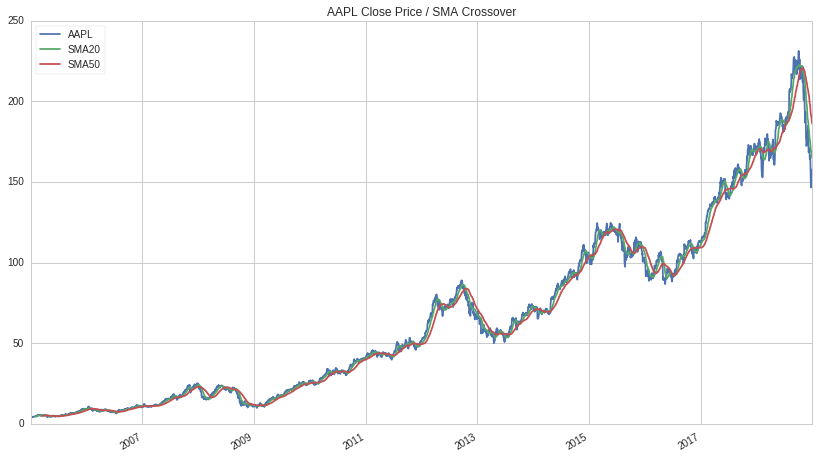

In [12]:

# Research environment functions
from quantopian.research import prices, symbols

# Pandas library: https://pandas.pydata.org/
import pandas as pd

# Query historical pricing data for AAPL
aapl_close = prices(
    assets=symbols('AAPL'),
    start='2005-01-01',
    end='2019-01-01',
)

# Compute 20 and 50 day moving averages on
# AAPL's pricing data

aapl_sma20 = aapl_close.rolling(20).mean()
aapl_sma50 = aapl_close.rolling(50).mean()

# Combine results into a pandas DataFrame and plot
pd.DataFrame({   
    'AAPL': aapl_close,
    'SMA20': aapl_sma20,
    'SMA50': aapl_sma50
}).plot(
    title='AAPL Close Price / SMA Crossover'
);



In [13]:
print(aapl_close.shape)
size_data = aapl_close.shape[0]

(3523,)


In [14]:
import numpy as np 
import numpy.random as rand
from math import sqrt
# Prefer all sma_i for each and every day in the source data
sred_value = np.zeros((61, size_data))
sum_ = 0.0
cnt = 0
for i in range(1, 61):
    sum_ = 0.0
    cnt = 0
    for j in range(0, size_data):
        sum_ += aapl_close[j]
        cnt += 1
        if cnt > i:
            sum_ -= aapl_close[j - i]
            cnt -= 1
        sred_value[i][j] = sum_ / cnt
    

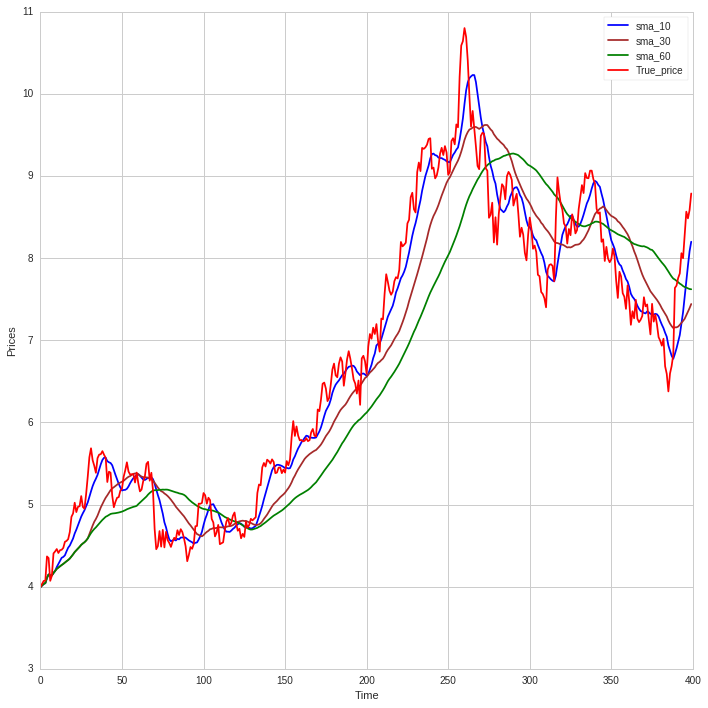

In [15]:
# We draw medium graphics to see what they look like.
import matplotlib.pyplot as plt
plt.subplots(figsize=(10, 10))
plt.plot(np.array(range(0, 400)), sred_value[10][:400], color='Blue', label='sma_10')
plt.plot(np.array(range(0, 400)), sred_value[30][:400], color='Brown', label='sma_30')
plt.plot(np.array(range(0, 400)), sred_value[60][:400], color='Green', label='sma_60')
plt.plot(np.array(range(0, 400)), aapl_close[:400], color='Red', label='True_price')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
def get_Sortino(alg_class):
        if alg_class.sortino != None:
            return alg_class.sortino
        """
        Income every month
        """
        Income = []
        for i in range(1, len(alg_class.amount_of_money)):
            Income.append(float((alg_class.amount_of_money[i] - alg_class.amount_of_money[i - 1])) / alg_class.amount_of_money[i - 1])
        Income = np.array(Income)
        average_income = Income.mean()
        # Counting the sum of squares of the difference of income to calculate the coefficient of Sortino
        sum_kv = 0
        for i in range(0, Income.size):
            if (Income[i] < average_income):
                sum_kv += (average_income - Income[i]) ** 2
        # Standard deviation of Sortino
        standard_deviation = sqrt(float(sum_kv) / Income.size)
        # Sortino coefficient (Risk-free income took for 0%)
        Sortino_coefficient = float(average_income) / standard_deviation
        alg_class.sortino = Sortino_coefficient
        return Sortino_coefficient

In [17]:
import numpy as np
class SmaAlg:
    def __init__(self, sma_low, sma_high, budget):
        self.sma_low = sma_low
        self.sma_high = sma_high
        self.amount_of_money = []
        self.sortino = None
        self.now_money = budget
        
    # runs the strategy on an array of prices by day, 
    #once a month assessing the balance and memorizing it
    def fit(self, X, sred_value_low, sred_value_high):
        day_in_month = 30
        self.amount_of_money.append(self.now_money)
        now_day = 0
        # Number of shares on hand
        cnt_stocks = 0
        for price in X:
            if (now_day + 1) % day_in_month == 0:
                self.amount_of_money.append(cnt_stocks * price + self.now_money)
            # If sma_low> = sma_high - you need to buy stocks
            if sred_value_low[now_day] >= sred_value_high[now_day]:
                cnt_stocks += (self.now_money // price)
                self.now_money -= (self.now_money // price) * price
            # If sma_low <sma_high - you need to sell stocks
            else:
                self.now_money += cnt_stocks * price
                cnt_stocks = 0
            now_day += 1
        self.now_money += cnt_stocks * X[-1]

training_range = [0, 3]
best_training_sortino = 0.877821589534
best_training_sma_low = 3
best_training_sma_high = 7
test_sortino = 0.462757731462


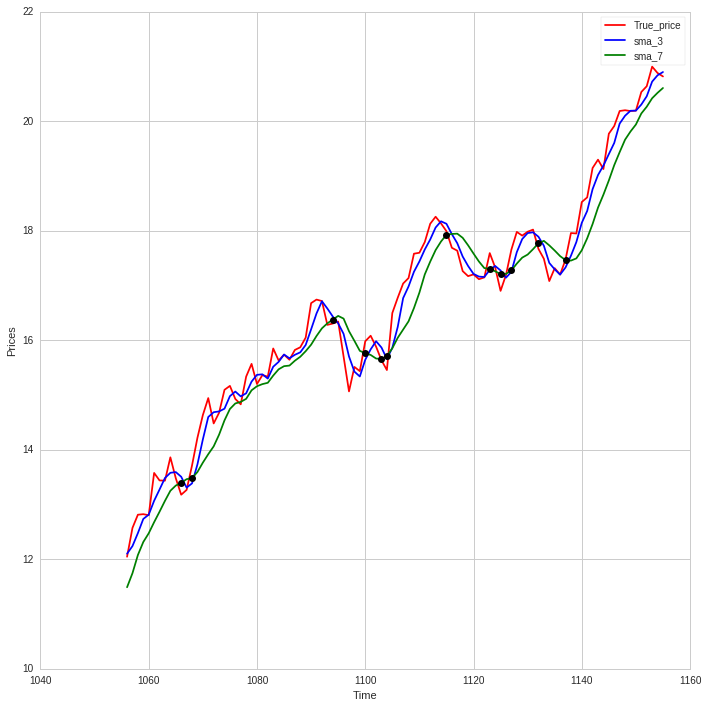

training_range = [0, 4]
best_training_sortino = 0.892216566085
best_training_sma_low = 2
best_training_sma_high = 9
test_sortino = 0.450741600557


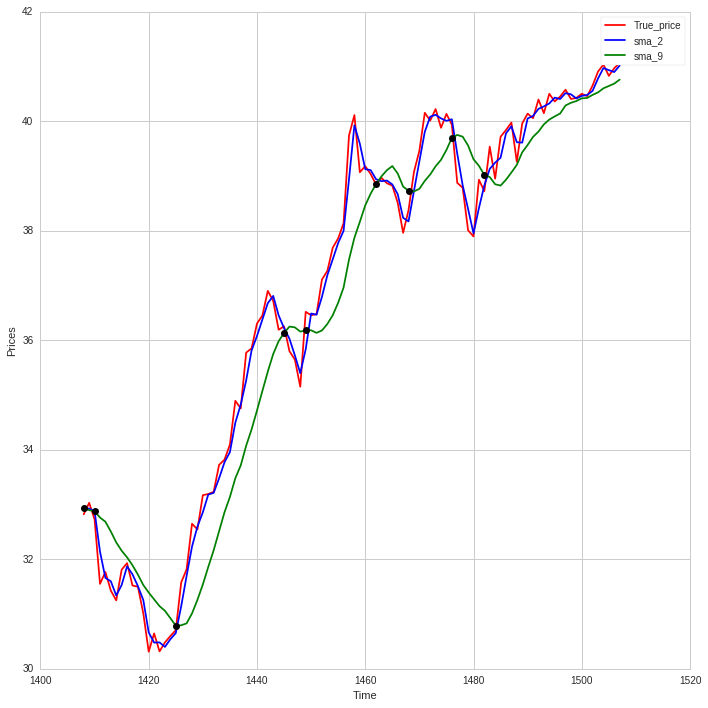

training_range = [0, 5]
best_training_sortino = 0.842255550065
best_training_sma_low = 4
best_training_sma_high = 6
test_sortino = 0.386619336364


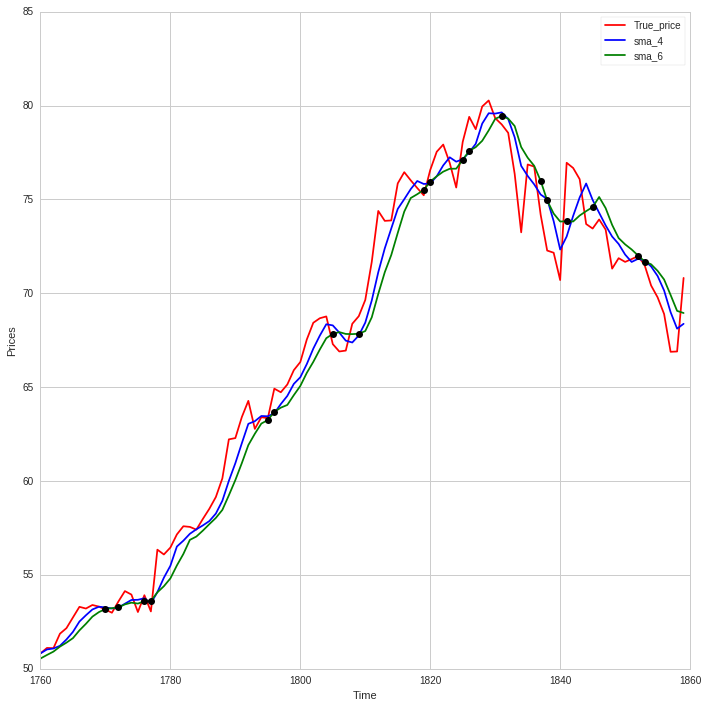

training_range = [0, 6]
best_training_sortino = 0.756384391975
best_training_sma_low = 2
best_training_sma_high = 6
test_sortino = 0.457180453161


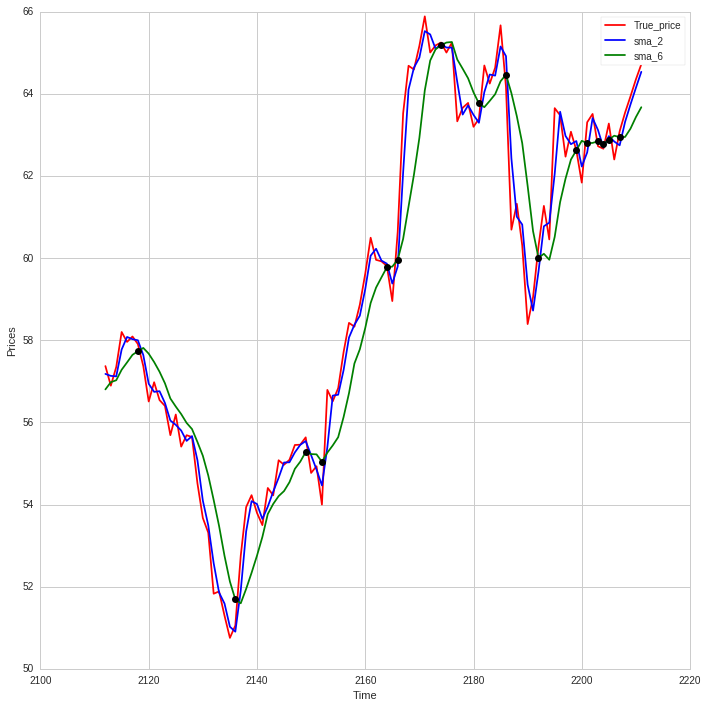

training_range = [0, 7]
best_training_sortino = 0.749658868826
best_training_sma_low = 2
best_training_sma_high = 6
test_sortino = 0.405483464429


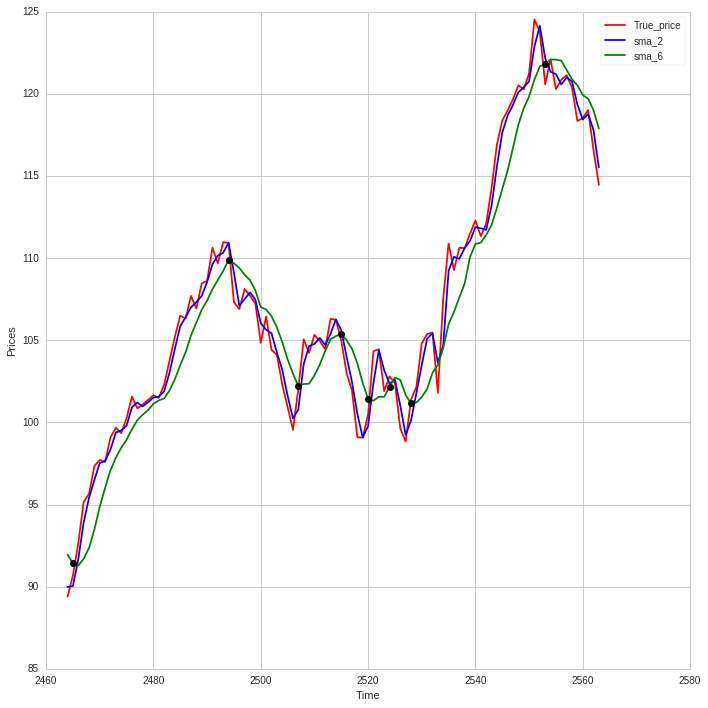

training_range = [0, 8]
best_training_sortino = 0.680355818789
best_training_sma_low = 2
best_training_sma_high = 6
test_sortino = 0.572290374357


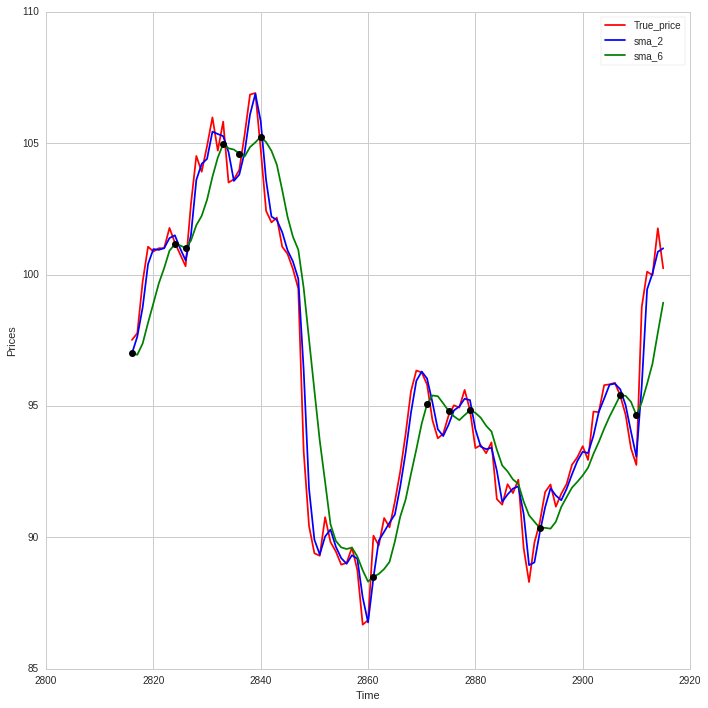

training_range = [0, 9]
best_training_sortino = 0.693080489662
best_training_sma_low = 2
best_training_sma_high = 6
test_sortino = 0.399110894613


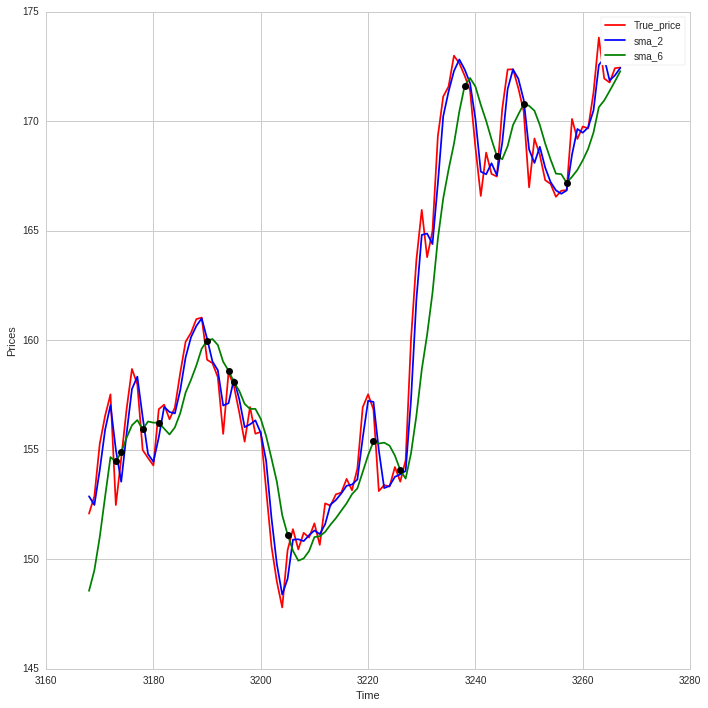

average test sortino = 0.447740550706


In [18]:
number_tests = 0
sum_sortino_test = 0
budget = 10000 # dollars
sortino_sma = None
"""
divide the sample into number_parts
"""
number_parts = 10

# Size of one path
size_path = size_data // number_parts
"""
the first three parts are training, the 4th test
the first 4 training, the 5th test
and etc.
"""


for left in range(3, number_parts):
    best_training_sortino = None
    best_training_sma_low = None
    best_training_sma_high = None
    """
    A selection of the best coefficients sma_low and sma_high on the train
    """
    for sma_low in range(2, 20):
        for sma_high in range(sma_low + 1, 60):
            my_class = SmaAlg(sma_low, sma_high, budget)
            my_class.fit(aapl_close[:left * size_path], 
                         sred_value[sma_low][:left * size_path], 
                         sred_value[sma_high][:left * size_path])
            training_sortino = get_Sortino(my_class)
            if best_training_sortino == None or best_training_sortino < training_sortino:
                best_training_sma_low = sma_low
                best_training_sma_high = sma_high
                best_training_sortino = training_sortino
    
    l_test = left * size_path
    r_test = (l_test + 1) * size_path
    """
    Checking the values found on the test
    """
    my_class = SmaAlg(best_training_sma_low, best_training_sma_high, budget)
    my_class.fit(aapl_close[l_test:r_test], 
                 sred_value[best_training_sma_low][l_test:r_test], 
                 sred_value[best_training_sma_high][l_test:r_test])

    sum_sortino_test += get_Sortino(my_class)
    print("training_range = [0, {}]\n".format(left) +  
          "best_training_sortino = {}\n".format(best_training_sortino) + 
          "best_training_sma_low = {}\n".format(best_training_sma_low) + 
          "best_training_sma_high = {}\n".format(best_training_sma_high) + 
          "test_sortino = {}".format(get_Sortino(my_class)))
    number_tests += 1
    
    l_graph = l_test
    r_graph = l_test + 100
    plt.subplots(figsize=(10, 10))
    
    plt.plot(np.array(range(l_graph, r_graph)), 
            aapl_close[l_graph:r_graph], 
            color='Red', 
            label='True_price')    

    plt.plot(np.array(range(l_graph, r_graph)), 
             sred_value[best_training_sma_low][l_graph:r_graph], 
             color='Blue', 
             label='sma_' + str(best_training_sma_low))

    plt.plot(np.array(range(l_graph, r_graph)), 
            sred_value[best_training_sma_high][l_graph:r_graph], 
            color='Green', 
            label='sma_' + str(best_training_sma_high))

    #Black dots mark the intersection of sma_low and sma_high - at these points you should buy or sell stocks
    idx = (np.argwhere(np.diff(np.sign(
        sred_value[best_training_sma_low][l_graph:r_graph] - 
        sred_value[best_training_sma_high][l_graph:r_graph]))).flatten()) + l_graph

    plt.plot(idx, sred_value[best_training_sma_high][idx], 'ro', color='Black')
    plt.xlabel('Time')
    plt.ylabel('Prices')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
print("average test sortino = " + str(float(float(sum_sortino_test) / number_tests)))  
sortino_sma = float(sum_sortino_test) / number_tests





In [19]:
import numpy as np
class Buy_and_Hold:
    def __init__(self, budget):
        self.amount_of_money = []
        self.sortino = None
        self.now_money = budget
        
    # runs the strategy on an array of prices by day, 
    #once a month assessing the balance and memorizing it
    def fit(self, X):
        day_in_month = 30
        self.amount_of_money.append(self.now_money)
        now_day = 0
        # Number of shares on hand
        cnt_stocks = 0
        for price in X:
            if (now_day + 1) % day_in_month == 0:
                self.amount_of_money.append(cnt_stocks * price + self.now_money)
            cnt_stocks += (self.now_money // price)
            self.now_money -= (self.now_money // price) * price
            now_day += 1
        self.now_money += cnt_stocks * X[-1]

In [20]:
day_in_year = 365
number_tests = 0
sum_sortino_test = 0
sortino_B_and_H = None

# Time during which it is planned to test the strategy buy_and_holf
size_buy_and_hold = day_in_year * 5
for left in range(0, size_data - size_buy_and_hold):
    """
    A selection of the best coefficients sma_low and sma_high on the train
    """
    right = left + size_buy_and_hold
    my_class = Buy_and_Hold(budget)
    my_class.fit(aapl_close[left:right])
    sum_sortino_test += get_Sortino(my_class)
    number_tests += 1
print("average_sortino = {}".format(sum_sortino_test / number_tests))
sortino_B_and_H = float(sum_sortino_test) / number_tests

average_sortino = 0.479522500219


In [25]:
sum_income_sma = 0
sum_income_buy_and_hold = 0
number_tests = 0
time_step = 100
factor = 1
size_test = day_in_year * factor
budget = 10000 # dollars
for left in range(day_in_year * 3, size_data - size_test, time_step):
    l_test = left
    r_test = left + size_test
    class_buy_and_hold = Buy_and_Hold(budget)
    class_buy_and_hold.fit(aapl_close[l_test:r_test])
    sum_income_buy_and_hold += class_buy_and_hold.now_money
    
    best_training_sortino = None
    best_training_sma_low = None
    best_training_sma_high = None
    """
    A selection of the best coefficients sma_low and sma_high on the train
    """
    for sma_low in range(2, 20):
        for sma_high in range(sma_low + 1, 60):
            my_class = SmaAlg(sma_low, sma_high, budget)
            my_class.fit(aapl_close[:l_test], 
                         sred_value[sma_low][:l_test], 
                         sred_value[sma_high][:l_test])
            training_sortino = get_Sortino(my_class)
            if best_training_sortino == None or best_training_sortino < training_sortino:
                best_training_sma_low = sma_low
                best_training_sma_high = sma_high
                best_training_sortino = training_sortino
    class_sma = SmaAlg(best_training_sma_low, best_training_sma_high, budget)
    class_sma.fit(aapl_close[l_test:r_test], 
                 sred_value[best_training_sma_low][l_test:r_test], 
                 sred_value[best_training_sma_high][l_test:r_test])
    sum_income_sma += class_sma.now_money
    print("test_range = [{}, {}]\n".format(l_test, r_test) +
        "sum_income_sma = {}\n".format(class_sma.now_money) +  
          "income_buy_and_hold = {}\n\n".format(class_buy_and_hold.now_money))
    number_tests += 1

test_range = [1095, 1460]
sum_income_sma = 15923.838
income_buy_and_hold = 23886.197


test_range = [1195, 1560]
sum_income_sma = 14960.488
income_buy_and_hold = 19549.276


test_range = [1295, 1660]
sum_income_sma = 16609.671
income_buy_and_hold = 18672.608


test_range = [1395, 1760]
sum_income_sma = 13276.973
income_buy_and_hold = 16120.802


test_range = [1495, 1860]
sum_income_sma = 15154.306
income_buy_and_hold = 17523.373


test_range = [1595, 1960]
sum_income_sma = 13975.345
income_buy_and_hold = 18008.988


test_range = [1695, 2060]
sum_income_sma = 11298.15
income_buy_and_hold = 11014.3


test_range = [1795, 2160]
sum_income_sma = 10420.051
income_buy_and_hold = 9301.103


test_range = [1895, 2260]
sum_income_sma = 10270.559
income_buy_and_hold = 9847.012


test_range = [1995, 2360]
sum_income_sma = 10752.059
income_buy_and_hold = 11648.675


test_range = [2095, 2460]
sum_income_sma = 12642.778
income_buy_and_hold = 16645.465


test_range = [2195, 2560]
sum_income_sma = 16627

In [28]:
# Доход в процентах годовых
print("Стратегия SMA\n" + 
    "средний доход = {}%, коэффициент Сортино = {}\n".format((sum_income_sma / number_tests - budget) / budget * 100, sortino_sma) +  
    "Стратегия B&H\n" + 
    "средний доход = {}%, коэффициент Сортино = {}\n".format((sum_income_buy_and_hold / number_tests - budget) / budget * 100, sortino_B_and_H))

Стратегия SMA
средний доход = 34.0012195238%, коэффициент Сортино = 0.447740550706
Стратегия B&H
средний доход = 50.5420085714%, коэффициент Сортино = 0.479522500219

